In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# This order is non-det

In [4]:
import os
import dill
control_names = os.listdir('controls_107')
controls = [dill.load(open(os.path.join('controls_107', c_name), 'rb')) for c_name in control_names]

In [5]:
mypath = 'controls_106'
_file = 'pickled_controls106.pkl'
filename = os.path.join(mypath, _file)
pca = dill.load(open(filename, 'rb'))

In [6]:
import numpy as np
pca.num_steps = 40
pca.dt = 5/2*np.pi/pca.num_steps
pca.controlset = controls

In [5]:
# Notes - including the full set of 640 controls didn't do much - however in this case, I also forgot to include the constraint that the 1RBCs are still 0RBCs.
# Removing these solutions *did* make the optimal control worse though. (I'm skipping many below) 
# Maybe I should include sparsity and normalization to get qualitatively different results

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
import dill
import numpy as np
import random
mypath = 'controls_106'
_file = 'pickled_controls106.pkl'
filename = os.path.join(mypath, _file)


In [9]:
import numpy as np
import dill
pca = dill.load(open(filename, 'rb'))
num_steps = 500
dt = 5/2 * np.pi/num_steps
pca.dt = dt
pca.num_steps = num_steps

In [10]:
# Keep every_ith control. Increase this if you want to decrease the number of controls being considered.
every_ith = 91

def bangbang(index, x, d1, d2, d3, d4, num_steps):
    if x:
        xory = 0
    else:
        xory = 1
    dt = pca.dt
    control_hamiltonians = pca.control_hamiltonians
    controls = np.zeros((num_steps, int(len(pca.control_hamiltonians))))
    choices = (np.random.rand(100) - .5)/1000 + 1
    choices = [1]
    controls[index, xory] = (1 / dt * np.pi / 2) * d1 * random.choice(choices)
    controls[-(index+1), xory] = 1 / dt * np.pi / 2 * d2 * random.choice(choices)
    controls[index, 2+xory] = 1 / dt * np.pi / 2 * d3 * random.choice(choices)
    controls[-(index+1), 2+xory] = 1 / dt * np.pi / 2 * d4 * random.choice(choices)
    return controls
random.seed(100)
np.random.seed(100)
controls = []
import itertools
for directions in list(itertools.product([-1, 1], repeat=4)):
    for x in (True, False):
        for i in range(int(pca.controlset[0].shape[0]/2)):
            if i % every_ith != 0:
                continue
            controls.append(bangbang(i, x, *directions, num_steps))
# Add on the do-nothing control
pca.controlset = []
pca.controlset += controls
pca.num_controls = len(pca.controlset)
pca.weights = None

In [11]:
from convex import all_derivs
derivs = all_derivs(pca.controlset, pca.target_operator, pca.control_hamiltonians, pca.ambient_hamiltonian, pca.dt, 1)
derivs[1] = [np.delete(d, 2, 0) for d in derivs[1]]

Control 0 derivative.
Control 1 derivative.
Control 2 derivative.
Control 3 derivative.
Control 4 derivative.
Control 5 derivative.
Control 6 derivative.
Control 7 derivative.
Control 8 derivative.
Control 9 derivative.
Control 10 derivative.
Control 11 derivative.
Control 12 derivative.
Control 13 derivative.
Control 14 derivative.
Control 15 derivative.
Control 16 derivative.
Control 17 derivative.
Control 18 derivative.
Control 19 derivative.
Control 20 derivative.
Control 21 derivative.
Control 22 derivative.
Control 23 derivative.
Control 24 derivative.
Control 25 derivative.
Control 26 derivative.
Control 27 derivative.
Control 28 derivative.
Control 29 derivative.
Control 30 derivative.
Control 31 derivative.
Control 0 derivative.
Control 1 derivative.
Control 2 derivative.
Control 3 derivative.
Control 4 derivative.
Control 5 derivative.
Control 6 derivative.
Control 7 derivative.
Control 8 derivative.
Control 9 derivative.
Control 10 derivative.
Control 11 derivative.
Control 

In [12]:
import scipy
[np.trace(scipy.linalg.expm(-1.j*d.reshape(4,4)))/4 for d in derivs[0]]

[(0.9999975326014685-2.927345865710862e-18j),
 (0.9999975326014685-3.2526065174565133e-18j),
 (-0.9999987662999348+1.0181119162864254e-19j),
 (-0.9999987662999348+1.2122384743740361e-19j),
 (-0.9999987662999348-1.0181119162864254e-19j),
 (-0.9999987662999348-1.2122384743740361e-19j),
 (0.9999975326014685+2.927345865710862e-18j),
 (0.9999975326014685+3.2526065174565133e-18j),
 (-0.9999987662999348-2.0220653831256856e-19j),
 (-0.9999987662999348-3.8957500317365647e-19j),
 (0.999997532601469-2.927345865710862e-18j),
 (0.999997532601469-3.0357660829594124e-18j),
 (0.999997532601469+2.927345865710862e-18j),
 (0.999997532601469+3.0357660829594124e-18j),
 (-0.9999987662999348+2.0220653831256856e-19j),
 (-0.9999987662999348+3.8957500317365647e-19j),
 (-0.9999987662999348+2.0220653831256856e-19j),
 (-0.9999987662999348+3.8957500317365647e-19j),
 (0.999997532601469+2.927345865710862e-18j),
 (0.999997532601469+3.0357660829594124e-18j),
 (0.999997532601469-2.927345865710862e-18j),
 (0.999997532601

In [13]:
import dill
_file = open('derivs', 'wb')
dill.dump(derivs, _file)

In [14]:
import matplotlib.pyplot as plt
def hist_and_support(weights, num=10):
    plt.hist(weights)
    np.argmax(weights)
    top_idx = np.argsort(np.array(weights).T)[0][-num:]
    top_values = [weights[i] for i in top_idx]
    print(f"SUPPORT:{np.sum(top_values)}")
    print(f"NUM CONTROLS: {num}")
    return top_idx, np.sum(top_values)

In [15]:
from pauli_channel_approximation import PCA

/home/anthony/repos/decorrelating_errors/code/pauli_channel_approximation.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/anthon

In [35]:
from convex import optimal_weights
pca.weights_0 = optimal_weights(derivs[:1], l1_constraint=True, l1_param=1)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 99              
  Cones                  : 2               
  Scalar variables       : 68              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 99              
  Cones               

In [36]:
# Strangely, just by adding more controls, it worked...

In [37]:
pca.weights_0

matrix([[ 6.24762485e-02],
        [ 6.24762485e-02],
        [-8.00338161e-10],
        [-8.00338161e-10],
        [-8.00338161e-10],
        [-8.00338161e-10],
        [ 6.24762485e-02],
        [ 6.24762485e-02],
        [-8.00338160e-10],
        [-8.00338161e-10],
        [ 6.25237530e-02],
        [ 6.25237530e-02],
        [ 6.25237530e-02],
        [ 6.25237530e-02],
        [-8.00338160e-10],
        [-8.00338161e-10],
        [-8.00338160e-10],
        [-8.00338161e-10],
        [ 6.25237530e-02],
        [ 6.25237530e-02],
        [ 6.25237530e-02],
        [ 6.25237530e-02],
        [-8.00338160e-10],
        [-8.00338161e-10],
        [ 6.24762485e-02],
        [ 6.24762485e-02],
        [-8.00338161e-10],
        [-8.00338161e-10],
        [-8.00338161e-10],
        [-8.00338161e-10],
        [ 6.24762485e-02],
        [ 6.24762485e-02]])

In [38]:
num_weights = len(pca.weights_0)

SUPPORT:0.9999999990527159
NUM CONTROLS: 32


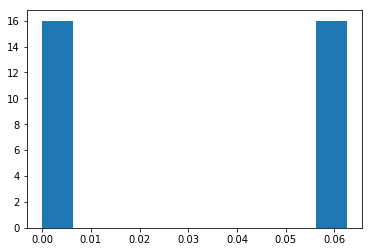

In [39]:
idx0, supp = hist_and_support(pca.weights_0, num_weights)

In [40]:
from convex import optimal_weights
pca.weights = optimal_weights(derivs)
# pca.weights[0] = .5
# pca.weights[1] = .5

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 227             
  Cones                  : 2               
  Scalar variables       : 164             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective se

SUPPORT:0.9999999980473147
NUM CONTROLS: 32


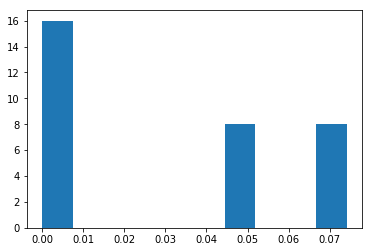

In [41]:
idx1, supp = hist_and_support(pca.weights, num_weights)

In [42]:
pca0 = dill.load(open(filename, 'rb'))
pca0.controlset = controls
subweights =  np.array(pca.weights_0)[idx0]
#pca.controlset += controls
#pca0.controlset += [np.zeros(controls[0].shape)]
pca0.weights = None


pca0.num_controls = len(pca0.controlset)
pca0.probs = list(np.array(subweights.T/sum(subweights)).T)

In [43]:
pca1 = dill.load(open(filename, 'rb'))
pca1.controlset = controls
subweights = np.array(pca.weights)[idx1]
# pca.controlset += controls
# pca.controlset += [np.zeros(controls[0].shape)]
pca.weights = None



pca1.num_controls = len(pca1.controlset)
pca1.probs = list(np.array(subweights.T/sum(subweights)).T)


In [44]:
import scipy
order = 0
# Zeroth order optimized weights
print('ZEROTH ORDER: {}'.format(scipy.linalg.norm(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx0]).T.dot(pca0.probs))))

ZEROTH ORDER: 0.0022214980843370544


In [45]:
import scipy
order = 0
# Zeroth order optimized weights
print("SUM: {}".format(sum(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx0]).T.dot(pca0.probs))))

SUM: [[0.00314167+2.32067574e-24j]]


In [46]:
import scipy
order = 1
print('FIRST ORDER: {}'.format(scipy.linalg.norm(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx0]).T.dot(pca0.probs))))

FIRST ORDER: 18.568384229814082


In [47]:
import scipy
order = 0
# Zeroth order optimized weights
print('ZEROTH ORDER: {}'.format(scipy.linalg.norm(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx1]).T.dot(pca1.probs))))

ZEROTH ORDER: 4.203448224846713e-09


In [48]:
import scipy
order = 0
# Zeroth order optimized weights
print("SUM: {}".format(sum(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx1]).T.dot(pca1.probs))))

SUM: [[-5.7827606e-09+3.9789971e-18j]]


In [49]:
import scipy
order = 1
print('FIRST ORDER: {}'.format(scipy.linalg.norm(np.matrix(np.array([d.flatten() for d in derivs[order]])[idx1]).T.dot(pca1.probs))))

FIRST ORDER: 0.04645381026023787


In [50]:
pca0.dt = pca.dt
pca1.dt = pca.dt
pca0.num_steps = pca.num_steps
pca1.num_steps = pca.num_steps
pca0.num_controls = len(pca0.controlset)
pca1.num_controls = len(pca1.controlset)

In [51]:
# pca0.dt = dt
# pca1.dt = dt
# pca0.num_steps = num_steps
# pca1.num_steps = num_steps
# pca0.num_controls = len(pca0.controlset)
# pca1.num_controls = len(pca1.controlset)

In [52]:
_file = 'pickled_controls106.pkl'
# Save the weighted controls
import dill
dill.dump(pca0, open('0_' + _file, 'wb'))

import dill
dill.dump(pca1, open('1_' + _file, 'wb'))

In [53]:
# Save the weighted controls
import dill
import os
import numpy as np


pca0 = dill.load(open('0_' + _file, 'rb'))
pca1 = dill.load(open('1_' + _file, 'rb'))

In [54]:
from pauli_channel_approximation import control_unitaries, error_unitary, off_diagonal_projection, adjoint
import sys
import itertools
from itertools import product
from copy import deepcopy
from functools import reduce
import numpy as np

from diamond import diamond_norm, jamiolkowski

def superoperator(unitary):

    return np.kron(unitary.conj(), unitary)

def choi_form(unitary):
    return np.matrix(jamiolkowski(superoperator(unitary)))

def diamond_distance(sopa, sopb):
#     unitary_a = np.matrix(unitary_a)
#     unitary_b = np.matrix(unitary_b)
#     arg = (choi_form(unitary_a) - choi_form(unitary_b))/2
#     rtn = diamond_norm(arg)
    rtn = (jamiolkowski(sopa) - jamiolkowski(sopb))/2
    return diamond_norm(rtn)

def compute_diamond_norm(data):
    controlset, ambient_hamiltonian0, combo, dt, control_hamiltonians, target_operator, probs = data
    print("DOING COMBO {}".format(combo))
    sys.stdout.flush()
    fidelities = []
    projs = []
    sops = []
    controlset_unitaries = []
    d_norms = []

    for i, controls in enumerate(controlset):
        newcontrols = deepcopy(controls)
        ambient_hamiltonian = [deepcopy(ah).astype("complex") for ah in ambient_hamiltonian0]
        for cnum, value in enumerate(combo):
            cnum -= len(ambient_hamiltonian0)
            if cnum >= 0:
                newcontrols[:, cnum] = newcontrols[:, cnum] * (1 + value)
            if cnum < 0:
                if cnum == -1:
                    ambient_hamiltonian[cnum] *= 1 + float(value)
                else:
                    ambient_hamiltonian[cnum] *= float(value)
        step_unitaries = control_unitaries(ambient_hamiltonian,
                                           control_hamiltonians, newcontrols,
                                           dt)
        unitary = reduce(lambda a, b: a.dot(b), step_unitaries)
        sop = error_unitary(unitary, target_operator)
        sops.append(sop)
        if i in list(range(1)):
            d_norms.append(diamond_distance(sop, np.eye(sop.shape[0])))
    avg_sop = reduce(lambda a, b: a + b, [prob * sops[i] for i, prob in enumerate(probs)])
    d_norms.append(diamond_distance(avg_sop, np.eye(avg_sop.shape[0])))
    return d_norms

def generate_indices(num_points, order_desired):
    num_indices = len(order_desired)
    tuples = product(range(num_points), repeat=num_indices)
    indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] 
                    for i in range(num_indices)]) for t in tuples]
    return indices

In [ ]:
import dill
all_results = []
base = np.logspace(-4.7, np.log(pca0.detunings[0][0])/np.log(10), 1)
controls = np.concatenate([np.sort(-base),np.array([0]), base]) * 100
combinations0 = [[det, 0, 0, 0, 0, 0, 0] for det in controls]
combinations1 = [[0, det, 0, 0, 0, 0, 0] for det in controls]
combinations2 = [[0, 0, det, 0, 0, 0, 0] for det in controls]
combinations3 = [[0, 0, 0, det, det, 0, 0] for det in controls]
combinations4 = [[0, 0, 0, 0, 0, det, det] for det in controls]

for j, pca in enumerate((pca0, pca1)):
    d_norms00 = []
    for i in range(len(combinations0)):
        combo = combinations0[i]
        lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs]
        d_norms00.append(compute_diamond_norm(lst))
        dill.dump(d_norms00, open('d_norms00_{}_{}'.format(i, j), 'wb'))
for j, pca in enumerate((pca0, pca1)):
    d_norms01 = []
    for i in range(len(combinations1)):
        combo = combinations1[i]
        lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs]
        d_norms01.append(compute_diamond_norm(lst))
        dill.dump(d_norms01, open('d_norms01_{}_{}'.format(i, j), 'wb'))
# for j, pca in enumerate((pca0, pca1)):
#     d_norms02 = []
#     for i in range(len(combinations2)):
#         combo = combinations2[i]
#         lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
#                 pca.control_hamiltonians, pca.target_operator, pca.probs]
#         d_norms02.append(compute_diamond_norm(lst))
#         dill.dump(d_norms02, open('d_norms02_{}_{}'.format(i, j), 'wb'))
for j, pca in enumerate((pca0, pca1)):
    d_norms03 = []
    for i in range(len(combinations3)):
        combo = combinations3[i]
        lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs]
        d_norms03.append(compute_diamond_norm(lst))
        dill.dump(d_norms03, open('d_norms03_{}_{}'.format(i, j), 'wb'))
for j, pca in enumerate((pca0, pca1)):
    d_norms04 = []
    for i in range(len(combinations4)):
        combo = combinations4[i]
        lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs]
        d_norms04.append(compute_diamond_norm(lst))
        dill.dump(d_norms04, open('d_norms04_{}_{}'.format(i, j), 'wb'))
        
#     all_results.extend([d_norms00, d_norms01, d_norms02, d_norms03, d_norms04])
# dill.dump(all_results, open('all_results', 'wb'))

DOING COMBO [-0.0019952623149688785, 0, 0, 0, 0, 0, 0]
DOING COMBO [0.0, 0, 0, 0, 0, 0, 0]
DOING COMBO [0.0019952623149688785, 0, 0, 0, 0, 0, 0]
DOING COMBO [-0.0019952623149688785, 0, 0, 0, 0, 0, 0]
DOING COMBO [0.0, 0, 0, 0, 0, 0, 0]
DOING COMBO [0.0019952623149688785, 0, 0, 0, 0, 0, 0]
DOING COMBO [0, -0.0019952623149688785, 0, 0, 0, 0, 0]
DOING COMBO [0, 0.0, 0, 0, 0, 0, 0]
DOING COMBO [0, 0.0019952623149688785, 0, 0, 0, 0, 0]
DOING COMBO [0, -0.0019952623149688785, 0, 0, 0, 0, 0]
DOING COMBO [0, 0.0, 0, 0, 0, 0, 0]
DOING COMBO [0, 0.0019952623149688785, 0, 0, 0, 0, 0]
DOING COMBO [0, 0, 0, -0.0019952623149688785, -0.0019952623149688785, 0, 0]
DOING COMBO [0, 0, 0, 0.0, 0.0, 0, 0]
DOING COMBO [0, 0, 0, 0.0019952623149688785, 0.0019952623149688785, 0, 0]
DOING COMBO [0, 0, 0, -0.0019952623149688785, -0.0019952623149688785, 0, 0]
DOING COMBO [0, 0, 0, 0.0, 0.0, 0, 0]
DOING COMBO [0, 0, 0, 0.0019952623149688785, 0.0019952623149688785, 0, 0]
DOING COMBO [0, 0, 0, 0, 0, -0.0019952623149

In [ ]:
# import dill
# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline
# which_parameter = 1


# d_norms00 = dill.load(open("d_norms0{}_2_0".format(which_parameter), 'rb'))
# d_norms10 = dill.load(open("d_norms0{}_2_1".format(which_parameter), 'rb'))
# controls = [-0.0019952623149688785, 0, 0.0019952623149688785]
# for a, b in ((d_norms00, d_norms10),):# (diamond_norms01, diamond_norms11)):
#     plt.figure(figsize=(10,6))
#     plt.semilogy(controls, np.array(a).T[7], linewidth = 2, alpha=.6, color='#a6bddb', label="Member of 0RBC", ls="-");
#     plt.semilogy(controls, np.array(b).T[7], linewidth = 2, alpha=.6, color='#a6bddb', label="Member of 1RBC", ls="--");


#     plt.semilogy(controls, np.array(a).T[-1], linewidth = 3, alpha=1, color='#2b8cbe', label="0RBC", ls="-");
#     plt.semilogy(controls,np.array(b).T[-1], linewidth = 3, alpha=1, color='#2b8cbe', label="1RBC", ls="--");
#     plt.ylabel("Diamond Norm")
#     plt.xlabel("Detuning")
#     plt.legend()